In [1]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import sys
sys.path.append("../src")
# from src import plot_multiomics

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection
warnings.simplefilter(action="ignore", category=FutureWarning)


file_path = "../data/EDD_isoprenol_production.csv"

INPUT_VARS = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
RESPONSE_VARS = ["Value"]

df = pd.read_csv(file_path, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]
df[INPUT_VARS] = df[INPUT_VARS].astype(int)
X_train = df[INPUT_VARS]
y_train = df[RESPONSE_VARS].values.ravel()
print(f"Shape of the data: {df.shape}")
# plot_multiomics.plot_distribution_of_designs(df[INPUT_VARS])

Shape of the data: (96, 9)


In [3]:
# # # Uncomment to run model selection
# modelSelection(X_train, y_train)

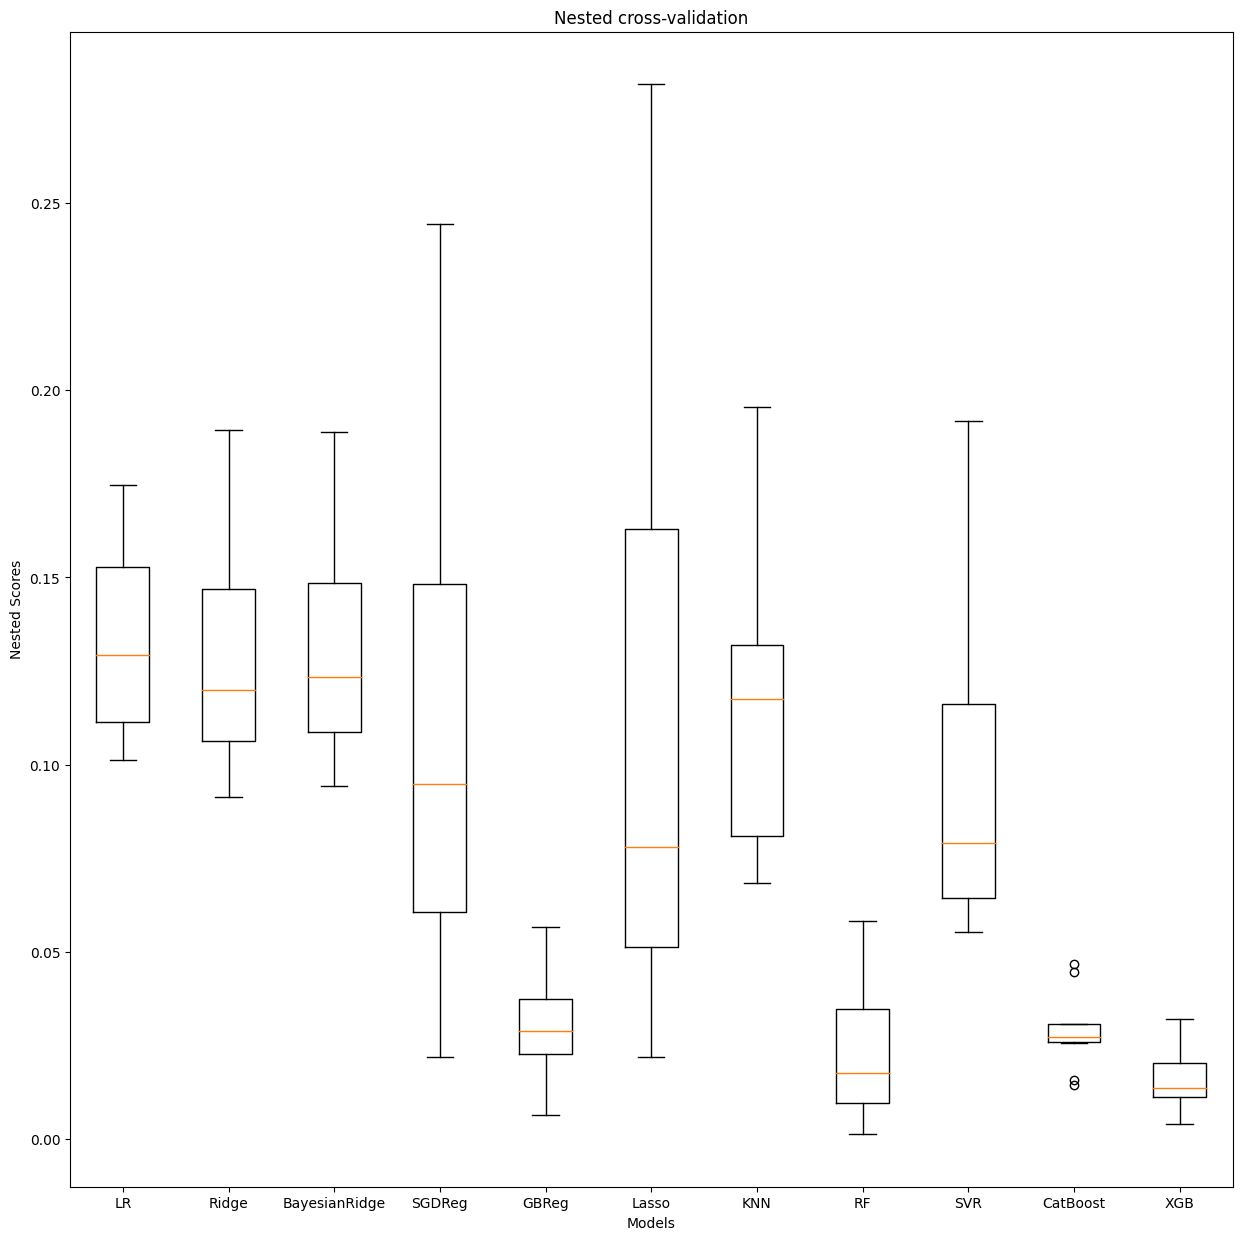

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X_train = df[INPUT_VARS]
y_train = df[RESPONSE_VARS].values.ravel()

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', [2, 3, 5, 6, 8])
    }
    
    model = RandomForestRegressor(**params)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

# save the model to disk using pickle
with open('../models/rf_isoprenol.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)

In [ ]:
# Pickle load model
with open('../models/rf_isoprenol.pkl', 'rb') as model_file:
    final_model = pickle.load(model_file)

In [7]:
import optuna
from sklearn.model_selection import cross_val_score
import xgboost as xgb

X_train = df[INPUT_VARS]
y_train = df[RESPONSE_VARS].values.ravel()

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 3, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12)
    }
    
    model = xgb.XGBRegressor(**params)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# save the model to disk using pickle
with open('../models/xgb_isoprenol.pkl', 'wb') as model_file:
    pickle.dump(final_model, model_file)

In [8]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Bootstraped Mean(MAE) = 0.030564633077666045


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8847452197825285, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03723890716793196, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Explainable AI 

ExactExplainer explainer: 97it [00:15,  2.10it/s]                        


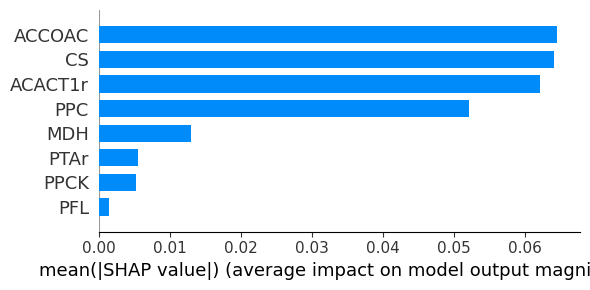

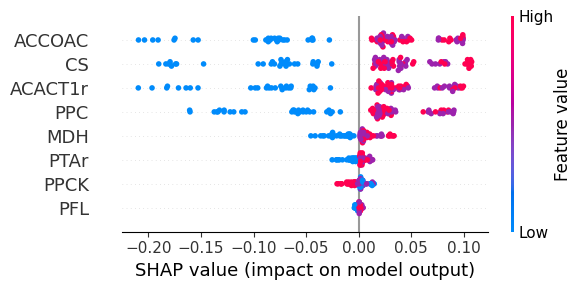

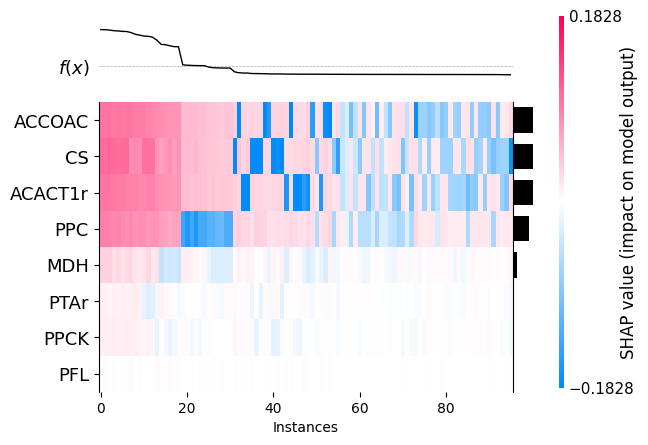

In [10]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.ExactExplainer(final_model.predict, df[INPUT_VARS])
shap_values = shap_explainer(df[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df[INPUT_VARS])
shap_df["true"] = df['Value']
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

In [ ]:
# feature = "PFL"
# pdplot(df[INPUT_VARS], feature, final_model, ice=False)
# shap_scatter(feature)

In [11]:
# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds

bounds = get_bounds(df, INPUT_VARS, epsilon=0)
bounds

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
min,0,0,0,0,0,0,0,0
max,2,2,2,2,2,2,2,2


In [12]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Caroternoi"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Caroternoi", ascending=False, inplace=True)
# Drop rows with Caroternoi < 0
sample_df = sample_df[sample_df["Caroternoi"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Caroternoi"]

X_synth = X_synth.round(0)
X_synth = X_synth.astype(int)

Intercept 0.013125629730518062
Prediction_local [0.37573163]
Right: 0.4543188


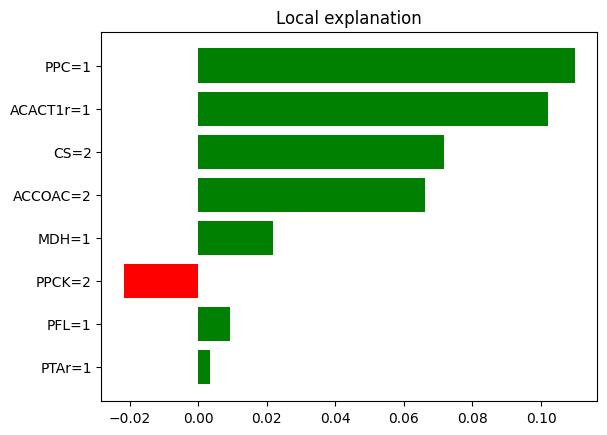

In [19]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_synth[INPUT_VARS].values, 
                                                   categorical_features=[i for i in range(len(INPUT_VARS))],
                                                   categorical_names=INPUT_VARS,
                                                   feature_names=X_synth[INPUT_VARS].columns.tolist(),  
                                                   verbose=True, mode='regression')
i = 1
exp = explainer.explain_instance(X_synth[INPUT_VARS].values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

In [20]:
sampling_bounds = pd.DataFrame(columns=INPUT_VARS, index=['min', 'max'])
sampling_bounds['ACCOAC'].loc['min'] = 1
sampling_bounds['ACCOAC'].loc['max'] = 2

sampling_bounds['MDH'].loc['min'] = 1
sampling_bounds['MDH'].loc['max'] = 2

sampling_bounds['PTAr'].loc['min'] = 1
sampling_bounds['PTAr'].loc['max'] = 2

sampling_bounds['CS'].loc['min'] = 1
sampling_bounds['CS'].loc['max'] = 2

sampling_bounds['ACACT1r'].loc['min'] = 0
sampling_bounds['ACACT1r'].loc['max'] = 2

sampling_bounds['PPC'].loc['min'] = 0
sampling_bounds['PPC'].loc['max'] = 2

sampling_bounds['PPCK'].loc['min'] = 0
sampling_bounds['PPCK'].loc['max'] = 1

sampling_bounds['PFL'].loc['min'] = 0
sampling_bounds['PFL'].loc['max'] = 2

In [21]:
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
63,2,2,2,2,2,1,0,1,0.562283
46,2,2,1,2,2,1,1,1,0.560974
4,1,2,1,2,2,1,1,0,0.559364
23,2,2,1,2,1,1,0,1,0.557897
70,1,2,2,2,2,1,0,0,0.554298
...,...,...,...,...,...,...,...,...,...
42,2,1,2,1,0,0,1,2,0.005570
52,1,1,1,2,0,0,1,1,0.001463
62,1,2,1,2,0,0,0,2,0.001104
29,2,1,2,2,0,0,1,1,0.000082


# Counterfactuals (`DiCE`)

In [22]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df.sort_values("Value", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[0.55, 0.80],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=True)
cf_df.sort_values("Value", ascending=False, inplace=True)

100%|██████████| 1/1 [00:19<00:00, 19.71s/it]


In [24]:
cf_df.sort_values("Value", ascending=False, inplace=True)
cf_df

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
0,2,2,2,2,2,1,0,1,0.562283
0,2,2,2,2,2,1,0,0,0.556076
0,2,2,1,2,2,1,0,2,0.554125
0,2,2,1,2,2,2,0,1,0.553497
0,2,2,2,2,2,1,0,2,0.553040
0,2,2,2,2,2,2,0,1,0.552412
0,2,2,2,2,2,2,0,2,0.551312
0,2,2,2,2,2,1,1,2,0.550646
0,2,2,2,2,2,2,1,1,0.550018


In [ ]:
# cf_df = pd.DataFrame()
# for i in range(len(e1.cf_examples_list)):
#     _ = e1.cf_examples_list[i].final_cfs_df
#     # Concatenate the dataframes
#     cf_df = pd.concat([cf_df, _], axis=0)

# cf_df.sort_values('Value', ascending=False, inplace=True)
# cf_df    